# 3. Práctica: Vectores a palabras

**Fecha de entrega: 16 de Marzo de 2025 @ 11:59pm**

## ***Ejercicio 1***

Obtenga la matriz de co-ocurrencia para un corpus en español y realice los siguientes calculos:
- Las probabilidades conjuntas
$$p(w_i,w_j) = \frac{c_{i,j}}{\sum_i \sum_j c_{i,j}}$$
- Las probabilidades marginales
$$p(w_i) = \sum_j p(w_i,w_j)$$
- Positive Point Wise Mutual Information (PPMI):
$$PPMI(w_i,w_j) = \max\{0, \log_2 \frac{p(w_i,w_j)}{p(w_i)p(w_j)}\}$$

### ***Bibliotecas***

In [1]:
# Math and iterations
import numpy as np
import random 
from collections import Counter
from itertools import combinations

# Visual
from rich import print as rprint
from tqdm.notebook import tqdm

# Datasets
import pandas as pd
from datasets import load_dataset

# NLP related 
import re 
import string 
import spacy 

### ***Variables globales***

In [2]:
random.seed(29)

### ***Funciones auxiliares***

In [3]:
def preprocess_text(text: str) -> list[str]:
    """
    Toma un texto y lo divide en oraciones y luego en tokens.
    
    :param text: El texto completo del cuento.
    :type text: str

    :return: Una lista de oraciones extraídas del texto, cada una de las cuales
             es una lista de palabras (tokens).
    :rtype: list of list of str    
    """
    # Eliminar espacios al inicio y al final
    text = text.strip()
    # Dividir el texto en oraciones usando una expresión regular que detecta
    # punto, signo de exclamación o interrogación seguido de espacios
    sentences = re.split(r'\n', text)
    
    tokens = [sentence.split(" ") for sentence in sentences]
    return tokens

In [4]:
def preprocess_sent(sent: list[str]) -> list[str]:
    """Función de preprocesamiento

    Agrega tokens de inicio y fin a la oración y normaliza todo a minusculas

    Params
    ------
    sent: list[str]
        Lista de palabras que componen la oración

    Return
    ------
    Las oración preprocesada
    """
    punctuation: str = string.punctuation + "¡¿—…«»“"
    result: list[str] = []
    for word in sent:
        
        word_pre = word.lower()
        word_pre = word_pre.translate(str.maketrans('', '', punctuation))
        if word_pre and word_pre not in nlp.Defaults.stop_words:
            # Aplicar lematización con spaCy
            doc = nlp(word_pre)
            lemma = doc[0].lemma_
            result.append(lemma)

    return result

In [5]:
def count_doc_frequencies(docs):
    """
    Cuenta la frecuencia de tokens en una lista de documentos.
    
    :param docs: Lista de documentos, donde cada documento es una lista de tokens.
    :type docs: list
    :return: Objeto Counter con la frecuencia de cada token en el corpus.
    :rtype: collections.Counter
    """
    tokens = [token for doc in docs for token in doc]
    return Counter(tokens)

In [6]:
def get_coocurrence_matrix(sentences: list[list[str]], indices: dict[str, int], n: int = 2) -> np.ndarray:
    matrix = np.zeros((len(indices), len(indices)))
    for sent in sentences:
        for term1, term2 in combinations(sent, 2):
            matrix[indices[term1], indices[term2]] += 1
            matrix[indices[term2], indices[term1]] += 1
    return matrix

In [7]:
def get_joint_probabilities(cooc_matrix: np.ndarray) -> np.ndarray:
    """
    Calcula las probabilidades conjuntas a partir de la matriz de coocurrencias.
    
    :param cooc_matrix: Matriz de coocurrencias (numpy.ndarray).
    :return: Matriz de probabilidades conjuntas p(w_i, w_j).
    """
    total = np.sum(cooc_matrix)
    joint_prob = cooc_matrix / total
    return joint_prob

In [8]:
def get_marginal_probabilities(joint_prob: np.ndarray) -> np.ndarray:
    """
    Calcula las probabilidades marginales a partir de la matriz de probabilidades conjuntas.
    
    :param joint_prob: Matriz de probabilidades conjuntas p(w_i, w_j).
    :return: Vector de probabilidades marginales p(w_i).
    """
    marginal_prob = np.sum(joint_prob, axis=1)
    return marginal_prob

In [9]:
def get_ppmi(joint_prob: np.ndarray, marginal_prob: np.ndarray) -> np.ndarray:
    """
    Calcula la matriz de Positive Pointwise Mutual Information (PPMI) a partir de las probabilidades conjuntas y marginales.
    
    :param joint_prob: Matriz de probabilidades conjuntas p(w_i, w_j).
    :param marginal_prob: Vector de probabilidades marginales p(w_i).
    :return: Matriz PPMI (numpy.ndarray).
    """
    # Se calcula el producto exterior de las probabilidades marginales
    with np.errstate(divide='ignore', invalid='ignore'):
        expected = np.outer(marginal_prob, marginal_prob)
        
        # Evitar división por cero utilizando np.divide con la condición where
        ratio = np.divide(joint_prob, expected, out=np.zeros_like(joint_prob), where=expected != 0)
        
        # Calcular el PMI con log2; se ignoran valores donde ratio <= 0
        pmi = np.log2(ratio, out=np.zeros_like(ratio), where=(ratio > 0))
        ppmi_matrix = np.maximum(pmi, 0)
    return ppmi_matrix

### ***Carga de datos***

Vamos a utilizar un corpus correspondiente a diferentes cuentos antiguos. 

In [10]:
ds = load_dataset("Fernandoefg/cuentos_es", split="train")

In [11]:
corpus: str = random.sample(ds["content"], 50)

### ***Preprocesamiento***

In [12]:
sentences = []
for doc in corpus:
    snts = preprocess_text(doc)
    sentences.extend(snts)

In [13]:
if spacy.prefer_gpu():
    spacy.require_gpu()

nlp = spacy.load("es_core_news_md")

corpus_processed = [preprocess_sent(sentence) for sentence in tqdm(sentences, 
                                                                   desc="Processing sentences",
                                                                   unit="sentence",
                                                                   dynamic_ncols=True)]

Processing sentences:   0%|                                                                              | 0/5…

In [14]:
for i, sent in enumerate(sentences[:3]):
    rprint(i, " ".join(preprocess_sent(sent)))

0 lugar extraño mente extraño región extraño espíritu elevado miserable periferia ciudad farola volver escaso 
gendarm patrullan pareja subir escalera casa avanzar acceder oblicua buhardilla genio joven pálido criminal sueño 
incur apáticamente brazo cruzado pensamiento llegar taller decoración barato insignificante artista solitario 
indignado consumido hambriento orgulloso luchar inmerso nube humo extremo confuso ideal hallarer hielo pureza 
carecer validez contrato concesión tolerancia mesura valor aire denso honesto miasma vida incapaz medrar regir 
obstinación extremo consecuencia reina desesperado libertad delirio muerte

1 viernes santo noche persona daniel invitado llegar instante recibir invitación formato cuartilla águila llevar 
aires cogido garra daga desenvainada escritura singular exhortar receptor asistir reunión celebrar viernes santo 
objeto lectura proclamación daniel hora fijado coincidir calle desierta sombrío arrabal frente banal edificio 
alquiler hallar morado terrenal profeta

2 conocer intercambiar saludo tratar pintor polaco flaco muchacha vivir poeta semita larguirucho barba negra 
acompañar voluminoso pálido esposa ataviado larga túnica colgant personalidad aspecto simultáneamente marcial 
enfermacer espiritista capitán caballeer servicio joven filósofo apariencia canguro novelista caballero sombrero 
rígido cuidado bigote único conocer proceder esfera distinto ir parar puro casualidad mantener relación vida libro 
leer circuito burgués decidido comportar él agradecimiento severo humildad criatura tolerado seguir distancia 
interior casa

### ***Matriz de concurrencia***

In [15]:
frecs = count_doc_frequencies(corpus_processed)

frecs.most_common()[:7]

[('ver', 551),
 ('hombre', 489),
 ('haber', 470),
 ('poder', 407),
 ('parecer', 374),
 ('ojo', 344),
 ('mirar', 324)]

In [16]:
indices = {token: idx for idx, token in enumerate(frecs.keys())}

In [17]:
coocurrence_matrix = get_coocurrence_matrix(corpus_processed, indices)

In [18]:
C = pd.DataFrame(data=coocurrence_matrix,
                 index=list(indices.keys()),
                 columns=list(indices.keys()))
C

,lugar,extraño,mente,región,espíritu,elevado,miserable,periferia,ciudad,farola,...,meceir él,ómnibu,chillón,llorón,relinchant,carruaj,gimir,arrasar,empuja,tuviérar
lugar,18.0,16.0,4.0,6.0,8.0,1.0,2.0,1.0,15.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
extraño,16.0,8.0,3.0,4.0,6.0,4.0,4.0,3.0,11.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mente,4.0,3.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
región,6.0,4.0,1.0,6.0,2.0,1.0,1.0,1.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
espíritu,8.0,6.0,2.0,2.0,8.0,1.0,1.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
carruaj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
gimir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
arrasar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
empuja,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [19]:
joint_prob = get_joint_probabilities(coocurrence_matrix)
jp = pd.DataFrame(data=joint_prob, index=list(indices.keys()), columns=list(indices.keys()))
jp

,lugar,extraño,mente,región,espíritu,elevado,miserable,periferia,ciudad,farola,...,meceir él,ómnibu,chillón,llorón,relinchant,carruaj,gimir,arrasar,empuja,tuviérar
lugar,3.804131e-06,3.381450e-06,8.453625e-07,1.268044e-06,1.690725e-06,2.113406e-07,4.226812e-07,2.113406e-07,3.170109e-06,6.340219e-07,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
extraño,3.381450e-06,1.690725e-06,6.340219e-07,8.453625e-07,1.268044e-06,8.453625e-07,8.453625e-07,6.340219e-07,2.324747e-06,8.453625e-07,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
mente,8.453625e-07,6.340219e-07,0.000000e+00,2.113406e-07,4.226812e-07,2.113406e-07,2.113406e-07,2.113406e-07,2.113406e-07,2.113406e-07,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
región,1.268044e-06,8.453625e-07,2.113406e-07,1.268044e-06,4.226812e-07,2.113406e-07,2.113406e-07,2.113406e-07,1.690725e-06,2.113406e-07,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
espíritu,1.690725e-06,1.268044e-06,4.226812e-07,4.226812e-07,1.690725e-06,2.113406e-07,2.113406e-07,2.113406e-07,6.340219e-07,4.226812e-07,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
carruaj,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,2.113406e-07,2.113406e-07,2.113406e-07,2.113406e-07,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
gimir,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.113406e-07,2.113406e-07,2.113406e-07
arrasar,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.113406e-07,0.000000e+00,2.113406e-07,2.113406e-07
empuja,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.113406e-07,2.113406e-07,0.000000e+00,2.113406e-07


In [20]:
# Calcular las probabilidades marginales
marginal_prob = get_marginal_probabilities(joint_prob)

mp = pd.DataFrame(marginal_prob, index=list(indices.keys()), columns=["p(w)"])
mp.head(5)

,p(w)
lugar,0.001499
extraño,0.000848
mente,0.000283
región,0.000318
espíritu,0.000514


In [21]:
ppmi_matrix = get_ppmi(joint_prob, marginal_prob)
pmi = pd.DataFrame(data=ppmi_matrix, index=list(indices.keys()), columns=list(indices.keys()))
pmi

,lugar,extraño,mente,región,espíritu,elevado,miserable,periferia,ciudad,farola,...,meceir él,ómnibu,chillón,llorón,relinchant,carruaj,gimir,arrasar,empuja,tuviérar
lugar,0.759084,1.411797,0.992449,1.410958,1.134209,1.119448,0.188018,3.114756,1.044962,1.860597,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
extraño,1.411797,1.234434,1.400049,1.648633,1.541809,3.942085,2.010655,5.522356,1.420140,3.098272,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
mente,0.992449,1.400049,0.000000,1.229285,1.537499,3.522738,1.591308,5.518047,0.000000,2.678925,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
región,1.410958,1.648633,1.229285,3.647794,1.371045,3.356284,1.424853,5.351592,2.374907,2.512470,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
espíritu,1.134209,1.541809,1.537499,1.371045,2.679258,2.664498,0.733067,4.659806,0.268083,2.820684,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
carruaj,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,10.508147,10.508147,10.508147,10.508147,0.0,0.000000,0.000000,0.000000,0.000000
gimir,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,14.173927,14.173927,14.173927
arrasar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,14.173927,0.000000,14.173927,14.173927
empuja,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,14.173927,14.173927,0.000000,14.173927


## ***Ejercicio 2:*** **Comparación de representaciones**

Aplica reducción de dimensionalidad (a 2D) de los vectores de la matríz con PPMI y de los vectores entrenados en español:

- Realiza un plot de 100 vectores aleatorios (que esten tanto en la matríz como en los vectores entrenados)
- Compara los resultados de los plots:
    - ¿Qué representación dirías que captura mejor relaciones semánticas?
    - Realiza un cuadro comparativo de ambos métodos con ventajas/desventajas

### 📁 [Carpeta con vectores](https://drive.google.com/drive/folders/1reor2FGsfOB6m3AvfCE16NOHltAFjuvz?usp=drive_link)

### ***Bibliotecas***

In [31]:
from gensim.models import word2vec
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

### ***Variables globales***

In [23]:
from enum import Enum

class Algorithms(Enum):
    CBOW = 0
    SKIP_GRAM = 1

### ***Funciones auxiliares***

In [24]:
def load_model(model_path: str):
    try:
        print(model_path)
        return word2vec.Word2Vec.load(model_path)
    except:
        print(f"[WARN] Model not found in path {model_path}")
        return None

In [32]:
def train_model(sentences: list, model_name: str, vector_size: int, window=5, workers=2, algorithm = Algorithms.CBOW):
    model_name_params = f"{model_name}-vs{vector_size}-w{window}-{algorithm.name}.model"
    model_path = "./" + model_name_params
    print(f"TRAINING: {model_path}")
    if algorithm in [Algorithms.CBOW, Algorithms.SKIP_GRAM]:
        model = word2vec.Word2Vec(
            sentences,
            vector_size=vector_size,
            window=window,
            workers=workers,
            sg = algorithm.value,
            seed=42,
            )
    else:
        print("[ERROR] algorithm not implemented yet :p")
        return
    try:
        model.save(model_path)
    except:
        print(f"[ERROR] Saving model at {model_path}")
    return model

### ***Entrenando modelo word2vec***

In [33]:
model = train_model(corpus_processed, model_name="my_corpus", 
                    vector_size=100, window=5, workers=4, 
                    algorithm=Algorithms.SKIP_GRAM)

TRAINING: ./my_corpus-vs100-w5-SKIP_GRAM.model


### ***Comparación de resultados***

In [34]:
common_words = set(indices.keys()).intersection(set(model.wv.key_to_index.keys()))
common_words = list(common_words)
print(f"Número de palabras comunes: {len(common_words)}")

selected_words = np.random.choice(common_words, size=100, replace=False)

Número de palabras comunes: 3362


In [35]:
word2vec_vectors = np.array([model.wv[word] for word in selected_words])

In [36]:
svd = TruncatedSVD(n_components=2, random_state=29)
reduced_matrix = svd.fit_transform(ppmi_matrix)

svd = PCA(n_components=2, random_state=29)
w2v_coords = svd.fit_transform(word2vec_vectors)

In [37]:
ppmi_coords = np.array([reduced_matrix[indices[word]] for word in selected_words])

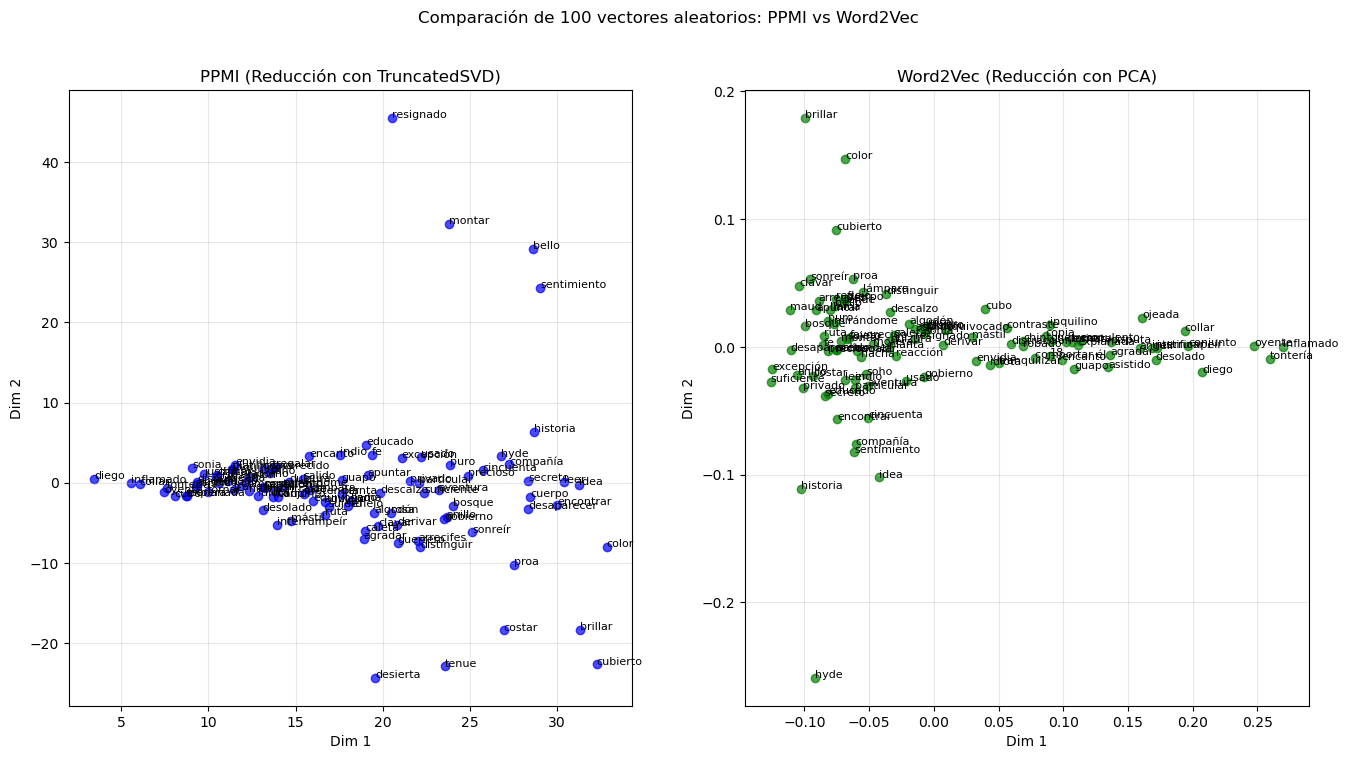

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot para PPMI
axs[0].scatter(ppmi_coords[:, 0], ppmi_coords[:, 1], color='blue', alpha=0.7)
for i, word in enumerate(selected_words):
    axs[0].annotate(word, (ppmi_coords[i, 0], ppmi_coords[i, 1]), fontsize=8)
axs[0].set_title("PPMI (Reducción con TruncatedSVD)")
axs[0].set_xlabel("Dim 1")
axs[0].set_ylabel("Dim 2")
axs[0].grid(alpha=0.3)

# Plot para Word2Vec
axs[1].scatter(w2v_coords[:, 0], w2v_coords[:, 1], color='green', alpha=0.7)
for i, word in enumerate(selected_words):
    axs[1].annotate(word, (w2v_coords[i, 0], w2v_coords[i, 1]), fontsize=8)
axs[1].set_title("Word2Vec (Reducción con PCA)")
axs[1].set_xlabel("Dim 1")
axs[1].set_ylabel("Dim 2")
axs[1].grid(alpha=0.3)

plt.suptitle("Comparación de 100 vectores aleatorios: PPMI vs Word2Vec")
plt.savefig("comparacion.png")
plt.show()

***Conclusión***

En la imagen se aprecia cómo la representación basada en PPMI (izquierda) tiende a distribuir las palabras en un espacio más amplio y con valores de coordenadas que varían mucho, mientras que la representación de Word2Vec (derecha) aparece más concentrada y “compacta”. Esto se debe principalmente a la naturaleza de cada método:

- PPMI + TruncatedSVD parte de una matriz de coocurrencia (estadística global) y, al aplicar SVD, genera un espacio donde las palabras que coocurren con frecuencia se agrupan. Se ve una dispersión mayor en los ejes porque la escala está determinada por la factorización de la matriz y puede reflejar de forma más literal la fuerza de coocurrencia.

- Word2Vec + PCA produce embeddings densos que capturan relaciones contextuales aprendidas de forma predictiva (CBOW o Skip-Gram). Al aplicar PCA, se reducen dimensiones conservando la mayor varianza posible. El resultado suele ser un espacio más “comprimido”, donde los patrones contextuales quedan reflejados en pequeñas variaciones de las coordenadas.

En términos de relaciones semánticas, ambas representaciones pueden agrupar palabras relacionadas; sin embargo:

- PPMI refleja asociaciones más directas basadas en coocurrencia global.

- Word2Vec tiende a capturar matices contextuales y, con suficiente corpus, agrupa palabras que aparecen en contextos similares, incluso si no coocurren de forma tan explícita.

***Cuadro Comparativo: PPMI vs Word2Vec***

| **Aspecto**            | **PPMI (con TruncatedSVD)**                                   | **Word2Vec (con PCA)**                                     |
|------------------------|---------------------------------------------------------------|------------------------------------------------------------|
| **Distribución del Espacio**  | Más dispersa; los ejes reflejan variaciones amplias de coocurrencia. | Más compacta y coherente; facilita la agrupación semántica.   |
| **Captura de Relaciones**     | Basada en coocurrencias directas; puede incluir ruido por tokens de alto uso. | Capta matices contextuales que facilitan la identificación de relaciones sutiles. |
| **Interpretabilidad**           | Más fácil de interpretar en términos de coocurrencias, pero menos preciso en matices. | Menos intuitivo en la fuente, pero las agrupaciones reflejan mejor la similitud semántica.  |
| **Eficiencia en Nuestro Caso**  | Representa asociaciones generales, pero con mayor dispersión en nuestro plot. | Representa relaciones semánticas de manera más clara y consistente en nuestro experimento. |
